In [1]:
import argparse
import torch
import numpy as np
import pandas as pd

import pickle
from torch_geometric.data import Dataset, download_url, DataLoader
#from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool, SAGPooling, GATConv, JumpingKnowledge, ASAPooling, GlobalAttention
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from models_multimodal import *
#from data_utils_multimodal import *
import random
from losses import *
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import copy

import torch.nn as nn
from sklearn.preprocessing import StandardScaler

#### Use/Check GPU availability

In [68]:
!nvidia-smi

Thu Oct 10 22:03:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:18:00.0 Off |                    0 |
| N/A   46C    P0             63W /  300W |     900MiB /  32768MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [67]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

## Load DNA methylation Data

- TCGA

#### Load selected CpGs info.

In [4]:
df_c_index = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/CpGs_c_indices.csv",
                         index_col=0)

c_index_larger_06 = df_c_index[df_c_index['c_index'] >= 0.60].copy()
c_index_larger_06

,CpG,c_index,c_index_adjusted_for_Demographics
5057,cg05225634,0.610713,0.660140
5139,cg26531551,0.602949,0.660140
8686,cg17019070,0.609546,0.660140
15595,cg00888336,0.608312,0.660140
40170,cg23471393,0.602029,0.669128
...,...,...,...
255689,cg09815377,0.603802,0.660140
255922,cg15135286,0.601961,0.679630
256684,cg13652008,0.604789,0.679787
257026,cg20021506,0.641278,0.683670


#### Get a list that we are going to use for retriving necessary info from TCGA data

In [5]:
CpG_list = c_index_larger_06['CpG'].tolist()
Final_list_TCGA = ['bcr_patient_barcode'] + CpG_list
Final_list_TCGA

['bcr_patient_barcode',
 'cg05225634',
 'cg26531551',
 'cg17019070',
 'cg00888336',
 'cg23471393',
 'cg27504195',
 'cg22840556',
 'cg08111960',
 'cg06742628',
 'cg22301418',
 'cg00675891',
 'cg10002850',
 'cg25940946',
 'cg06572115',
 'cg14845609',
 'cg26472225',
 'cg05956608',
 'cg23459424',
 'cg06985664',
 'cg00691123',
 'cg18118490',
 'cg26443646',
 'cg18396403',
 'cg12147622',
 'cg13823492',
 'cg14153654',
 'cg11876492',
 'cg09315662',
 'cg25768108',
 'cg20337860',
 'cg21795221',
 'cg01798266',
 'cg10655396',
 'cg01971590',
 'cg02101812',
 'cg03216823',
 'cg09816282',
 'cg26640901',
 'cg05103064',
 'cg19091779',
 'cg08818866',
 'cg16264004',
 'cg17280129',
 'cg24144853',
 'cg14781778',
 'cg07921759',
 'cg15519096',
 'cg20078807',
 'cg00221794',
 'cg03147185',
 'cg23316191',
 'cg16734981',
 'cg25545323',
 'cg15227982',
 'cg11897736',
 'cg20148334',
 'cg00613113',
 'cg22230912',
 'cg02347312',
 'cg04118190',
 'cg25978218',
 'cg22277567',
 'cg15085205',
 'cg22495636',
 'cg07339236',
 

In [6]:
DNAm_TCGA = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/betas_filtered.csv", index_col=0)

DNAm_TCGA['Patient ID'] = DNAm_TCGA['Patient ID'].str.slice(0, 12) 
DNAm_TCGA = DNAm_TCGA.drop_duplicates(subset=['Patient ID'])
DNAm_TCGA = DNAm_TCGA.drop(['vital_status', 'survival_time'], axis=1)
DNAm_TCGA.rename(columns={'Patient ID':'bcr_patient_barcode'}, inplace=True)

# Select required CpGs
DNAm_TCGA = DNAm_TCGA[Final_list_TCGA]

DNAm_TCGA

,bcr_patient_barcode,cg05225634,cg26531551,cg17019070,cg00888336,cg23471393,cg27504195,cg22840556,cg08111960,cg06742628,...,cg10495270,cg14945937,cg24810242,cg19832832,cg16936094,cg09815377,cg15135286,cg13652008,cg20021506,cg10939949
TCGA-2F-A9KO-01A-11D-A38H-05,TCGA-2F-A9KO,0.837784,0.981013,0.951071,0.937605,0.749643,0.944755,0.932084,0.603330,0.741496,...,0.151724,0.277698,0.750416,0.882155,0.600138,0.918051,0.664477,0.773110,0.841669,0.890933
TCGA-2F-A9KP-01A-11D-A38H-05,TCGA-2F-A9KP,0.899319,0.981357,0.988850,0.686949,0.807301,0.940359,0.979809,0.700172,0.393091,...,0.146651,0.300981,0.821290,0.722304,0.762778,0.925459,0.714181,0.705476,0.827397,0.821370
TCGA-2F-A9KQ-01A-11D-A38H-05,TCGA-2F-A9KQ,0.982691,0.979576,0.988919,0.961668,0.947546,0.948513,0.984863,0.913353,0.632312,...,0.079379,0.146920,0.886119,0.833670,0.404773,0.712327,0.814167,0.852450,0.876744,0.904580
TCGA-2F-A9KR-01A-11D-A38H-05,TCGA-2F-A9KR,0.967681,0.980804,0.989286,0.963762,0.517386,0.606263,0.977937,0.789238,0.553982,...,0.105844,0.195873,0.815282,0.862418,0.827871,0.695567,0.353144,0.342960,0.879421,0.898443
TCGA-2F-A9KT-01A-11D-A38H-05,TCGA-2F-A9KT,0.966785,0.978021,0.987715,0.571738,0.560154,0.279121,0.977911,0.356490,0.594080,...,0.184155,0.277295,0.606930,0.804098,0.929534,0.947407,0.523803,0.551288,0.774564,0.893740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZF-AA56-01A-31D-A392-05,TCGA-ZF-AA56,0.705956,0.970438,0.912332,0.944262,0.830663,0.911957,0.867241,0.443131,0.656783,...,0.104621,0.207807,0.711217,0.849144,0.806734,0.947649,0.427439,0.418104,0.795927,0.794004
TCGA-ZF-AA58-01A-12D-A42F-05,TCGA-ZF-AA58,0.790278,0.977962,0.990405,0.964094,0.818960,0.892965,0.981020,0.529384,0.744260,...,0.139107,0.217533,0.706081,0.863055,0.868221,0.960161,0.515115,0.545605,0.708026,0.904428
TCGA-ZF-AA5H-01A-11D-A392-05,TCGA-ZF-AA5H,0.542398,0.293778,0.494823,0.411380,0.283506,0.718350,0.890105,0.458030,0.119492,...,0.165180,0.187344,0.407292,0.625627,0.914021,0.949705,0.397196,0.446391,0.434656,0.902235
TCGA-ZF-AA5N-01A-11D-A42F-05,TCGA-ZF-AA5N,0.717706,0.853315,0.979398,0.538592,0.207609,0.146909,0.774580,0.242520,0.236341,...,0.078221,0.470969,0.690921,0.821566,0.950479,0.941019,0.679370,0.760047,0.535489,0.357302


- DH

In [7]:
DNAm_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_DNAm.csv")
DNAm_df = DNAm_df.dropna(subset=['file_name']) # Remove subjects without WSI files
DNAm_df['TenYearSurv'] = DNAm_df['TenYearSurv'].transform(lambda x: x*30)
DNAm_df['TenYearRFS'] = DNAm_df['TenYearRFS'].transform(lambda x: x*30)

# Select columns that we are going to use
Final_list_DH = ['FFPE.DNA.ID'] + CpG_list

DNAm_df = DNAm_df[Final_list_DH]
DNAm_df = DNAm_df.drop_duplicates()
DNAm_df

/dartfs-hpc/rc/home/q/f0034wq/.conda/envs/GNN_test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,FFPE.DNA.ID,cg05225634,cg26531551,cg17019070,cg00888336,cg23471393,cg27504195,cg22840556,cg08111960,cg06742628,...,cg10495270,cg14945937,cg24810242,cg19832832,cg16936094,cg09815377,cg15135286,cg13652008,cg20021506,cg10939949
0,BLD050,0.877704,0.786659,0.839499,0.865888,0.728421,0.808506,0.852304,0.707109,0.515407,...,0.207127,0.282681,0.842091,0.903338,0.616532,0.849071,0.747588,0.764547,0.852336,0.814271
1,BLD043,0.903778,0.867272,0.900368,0.869694,0.731232,0.856934,0.856771,0.601102,0.701621,...,0.128019,0.202235,0.904845,0.836256,0.740190,0.903272,0.773686,0.888653,0.906822,0.925455
3,BLD061,0.902834,0.867456,0.917442,0.891382,0.803706,0.879241,0.898172,0.827605,0.744796,...,0.133984,0.284466,0.899061,0.898545,0.428867,0.860190,0.810281,0.878705,0.886499,0.922573
5,BLD046,0.754699,0.819857,0.866117,0.840502,0.686702,0.798214,0.886572,0.533913,0.645897,...,0.299376,0.247461,0.843026,0.872031,0.766565,0.903650,0.628902,0.664677,0.860748,0.879639
6,BLD080,0.893368,0.856649,0.918326,0.888892,0.808537,0.860444,0.893033,0.830059,0.700348,...,0.134661,0.144009,0.869246,0.890036,0.285618,0.766759,0.756864,0.805967,0.882804,0.943498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,BLD048,0.879058,0.834640,0.912846,0.897745,0.711923,0.824190,0.910825,0.758210,0.535456,...,0.095472,0.114265,0.879650,0.840989,0.308320,0.666527,0.793871,0.811860,0.737637,0.626453
137,BLD075,0.911727,0.821464,0.893815,0.871907,0.812076,0.862533,0.894164,0.754496,0.571225,...,0.082056,0.167338,0.881925,0.890591,0.581825,0.869454,0.831428,0.718227,0.873276,0.888269
138,BLD024,0.912582,0.845036,0.917029,0.838250,0.825074,0.867046,0.873076,0.846477,0.676634,...,0.147564,0.188355,0.900222,0.873125,0.262840,0.816359,0.784172,0.826778,0.858617,0.894181
139,BLD094,0.914064,0.847266,0.919755,0.859747,0.787815,0.870577,0.898136,0.814811,0.569457,...,0.193725,0.160923,0.843627,0.858990,0.376555,0.708235,0.731184,0.785713,0.919905,0.904419


## Load HiTIMED Data

- TCGA

In [8]:
HiTIMED_TCGA_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/TCGA_HiTIMED_with_Survival_20240509.csv",
                             index_col=0)
HiTIMED_TCGA_df = HiTIMED_TCGA_df.drop_duplicates(subset=['submitter_id'])
HiTIMED_TCGA_df = HiTIMED_TCGA_df.drop(['vital_status', 'survival_time'], axis=1)
HiTIMED_TCGA_df.rename(columns={'submitter_id':'bcr_patient_barcode'}, inplace=True)

HiTIMED_TCGA_df

,bcr_patient_barcode,Tumor,Endothelial,Epithelial,Stromal,Bnv,Bmem,CD4nv,CD4mem,Treg,CD8nv,CD8mem,Mono,DC,NK,Bas,Eos,Neu
277,TCGA-2F-A9KO,59.496435,3.061159,0.000000,4.502154,0.000000,8.404918,0.0,1.838353,1.508797,0.220441,14.009471,0.000000,5.085653,1.872621,0.000000,0.000000,0.000000
96,TCGA-2F-A9KP,77.559634,6.398107,0.079715,3.772901,0.000000,2.361156,0.0,0.237921,1.102857,0.000000,1.418432,0.000000,2.673416,1.764794,0.858058,1.773009,0.000000
301,TCGA-2F-A9KQ,88.570479,1.588447,4.246925,1.060853,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.533296,0.000000,0.000000
191,TCGA-2F-A9KR,82.046167,5.968081,7.698402,0.615840,0.000000,0.000000,0.0,2.403660,0.000000,0.884687,0.383162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
81,TCGA-2F-A9KT,58.215044,5.653344,0.000000,6.824711,0.000000,0.843665,0.0,0.000000,0.000000,0.000000,3.275757,3.080379,6.837927,3.283591,1.241541,0.000000,10.744043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,TCGA-ZF-AA56,56.032282,6.010198,6.312032,4.271523,0.000000,6.938654,0.0,3.126088,1.146210,0.000000,3.198236,0.000000,7.094663,0.699691,0.464068,1.607831,3.098525
41,TCGA-ZF-AA58,45.918822,4.505245,0.000000,9.165651,0.000000,3.744179,0.0,4.206508,5.394365,0.000000,1.071090,0.000000,14.456026,3.687531,0.099868,1.865883,5.884833
79,TCGA-ZF-AA5H,73.982262,1.632842,0.000000,6.839488,2.697143,2.343099,0.0,1.801079,9.184619,0.000000,1.294674,0.000000,0.000000,0.224793,0.000000,0.000000,0.000000
218,TCGA-ZF-AA5N,72.724511,1.721571,0.495669,7.179986,0.000000,4.173312,0.0,0.000000,1.358315,0.000000,0.000000,0.000000,3.327464,4.807795,0.311276,0.297592,3.602511


- DH

In [9]:
HiTIMED_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_HiTIMED.csv")
HiTIMED_df = HiTIMED_df.dropna(subset=['file_name']) # Remove subjects without WSI files
HiTIMED_df = HiTIMED_df[HiTIMED_df['file_name'] != '205943_.svs'] # "205943_.pkl" < 810 byte
HiTIMED_df['TenYearSurv'] = HiTIMED_df['TenYearSurv'].transform(lambda x: x*30)
HiTIMED_df['TenYearRFS'] = HiTIMED_df['TenYearRFS'].transform(lambda x: x*30)
HiTIMED_df

,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood,Batch,Sex,Age,Grade,Grade2,Muscle_Invasive,BCG,...,CD4mem,Treg,CD8nv,CD8mem,Mono,DC,NK,Bas,Eos,Neu
0,BLD050,A00000FBK,203723190040_R08C01,Batch_3,male,77,grade 3,Grade 3 + 4,no,Without Immuno,...,0.000000,5.580140,0.0,3.388986,0.000000,0.000000,2.652840,0.000000,0.000000,0.0
1,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,77,grade 3,Grade 3 + 4,no,Without Immuno,...,0.185204,1.613221,0.0,3.676642,1.383615,5.232480,1.701208,0.000000,0.000000,0.0
2,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,77,grade 3,Grade 3 + 4,no,Without Immuno,...,0.185204,1.613221,0.0,3.676642,1.383615,5.232480,1.701208,0.000000,0.000000,0.0
3,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,76,grade 1,Grade 1 + 2,no,Without Immuno,...,0.997968,1.589810,0.0,3.141940,0.000000,4.534836,2.254315,0.073649,0.205418,0.0
4,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,76,grade 1,Grade 1 + 2,no,Without Immuno,...,0.997968,1.589810,0.0,3.141940,0.000000,4.534836,2.254315,0.073649,0.205418,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,BLD048,BDB1P03023,202163530099_R07C01,Batch_1,male,58,grade 2,Grade 1 + 2,no,Without Immuno,...,2.428655,1.116786,0.0,2.827982,0.000000,0.000000,1.453588,0.618560,0.974700,0.0
137,BLD075,BDB1P04022,202172220150_R06C01,Batch_1,male,51,grade 1,Grade 1 + 2,no,Without Immuno,...,1.010792,2.579993,0.0,0.000000,0.000000,0.000000,0.000000,2.200406,0.000000,0.0
138,BLD024,BDB1P02094,202163530080_R06C01,Batch_1,male,68,grade 1,Grade 1 + 2,no,Without Immuno,...,1.592609,2.059939,0.0,1.649354,3.207488,0.000000,0.704491,0.724507,0.487317,0.0
139,BLD094,BDB1P03058,202163550181_R02C01,Batch_1,male,53,grade 1,Grade 1 + 2,no,Without Immuno,...,0.620439,0.556929,0.0,1.327215,0.388502,0.000000,0.000000,0.287847,0.132852,0.0


In [10]:
Muscle_invasive_count = HiTIMED_df['Muscle_Invasive'].value_counts()
Muscle_invasive_count

no     115
yes     21
Name: Muscle_Invasive, dtype: int64

## Load WSI Data

In [11]:
WSI_TCGA_info = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/wsi_metadata_with_patches_and_embeddings_and_graphs.csv",index_col=0)
WSI_TCGA_info

,bcr_patient_barcode,age_at_diagnosis,cigarettes_per_day,primary_diagnosis,tissue_or_organ_of_origin,ajcc_pathologic_stage,race,gender,prior_malignancy,vital_status,ajcc_pathologic_t,ajcc_pathologic_n,ajcc_pathologic_m,survival_time,patches_npy,patches_pkl,embeddings,graphs
0,TCGA-2F-A9KO,63.898630,3.780822,Transitional cell carcinoma,Posterior wall of bladder,Stage IV,white,male,no,1,T3,N1,M0,734.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
1,TCGA-2F-A9KP,66.926027,3.397260,Transitional cell carcinoma,Lateral wall of bladder,Stage IV,white,male,no,1,T3a,N2,MX,364.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
2,TCGA-2F-A9KP,66.926027,3.397260,Transitional cell carcinoma,Lateral wall of bladder,Stage IV,white,male,no,1,T3a,N2,MX,364.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
3,TCGA-2F-A9KQ,69.202740,0.000000,Transitional cell carcinoma,"Bladder, NOS",Stage III,white,male,no,0,T3a,N0,M0,2886.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
4,TCGA-2F-A9KR,59.857534,1.232877,Papillary transitional cell carcinoma,"Bladder, NOS",Stage III,not reported,female,no,1,T3a,N0,M0,3183.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,TCGA-ZF-AA54,71.583562,0.000000,Transitional cell carcinoma,Lateral wall of bladder,Stage III,white,male,no,1,T3,NX,MX,590.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
452,TCGA-ZF-AA58,61.778082,2.136986,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,0,T3a,N2,MX,1649.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
453,TCGA-ZF-AA5H,60.608219,0.438356,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,0,T3b,N2,M0,897.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
454,TCGA-ZF-AA5N,62.304110,0.547945,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,1,T2,NX,M1,168.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...


## Get Demogrphics and Tumor stage, then, Convert categorical variables into dummy variables

- TCGA

In [12]:
TCGA_Pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/BLCA_TCGA_meta_data.csv").sort_values(by='bcr_patient_barcode', ascending=True).reset_index(drop=True)
TCGA_Pheno = TCGA_Pheno[['bcr_patient_barcode', 'age_at_diagnosis', 'gender', 'ajcc_pathologic_stage']].copy()
TCGA_Pheno.rename({'age_at_diagnosis': 'Age',
                   'gender': 'Gender',
                   'ajcc_pathologic_stage': 'Tumor_Stage'}, axis=1, inplace=True)
TCGA_Pheno.replace({'Tumor_Stage': {"0": 'cis_Stage_0',
                                    'Stage I':'Stage_I', 'Stage II':'Stage_II',
                                    'Stage III':'Stage_III', 'Stage IV':'Stage_IV'},
                    'Gender':{'female':0, 'male':1}}, inplace = True)

TCGA_Pheno = TCGA_Pheno.drop_duplicates()

stand = StandardScaler()
TCGA_Pheno['Age_stand'] = stand.fit_transform(TCGA_Pheno['Age'].values.reshape(-1,1))

TCGA_Pheno_Dummy = pd.get_dummies(TCGA_Pheno, columns=['Tumor_Stage'],
                                  drop_first=False, prefix=['Stage'])

TCGA_Pheno_Dummy

,bcr_patient_barcode,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-2F-A9KO,63.898630,1,-0.408341,0,0,0,1,0
1,TCGA-2F-A9KP,66.926027,1,-0.135424,0,0,0,1,0
2,TCGA-2F-A9KQ,69.202740,1,0.069820,0,0,1,0,0
3,TCGA-2F-A9KR,59.857534,0,-0.772643,0,0,1,0,0
4,TCGA-2F-A9KT,83.616438,1,1.369205,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
407,TCGA-ZF-AA56,79.279452,0,0.978229,0,0,1,0,0
408,TCGA-ZF-AA58,61.778082,0,-0.599507,0,0,0,1,0
409,TCGA-ZF-AA5H,60.608219,0,-0.704970,0,0,0,1,0
410,TCGA-ZF-AA5N,62.304110,0,-0.552086,0,0,0,1,0


- DH

In [13]:
DH_pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_HiTIMED.csv")
DH_pheno = DH_pheno.loc[:,['FFPE.DNA.ID', 'Age', 'Sex', 'stage2']]
DH_pheno = DH_pheno.drop_duplicates()
DH_pheno.rename({'Sex': 'Gender',
                 'stage2': 'Tumor_Stage'}, axis=1, inplace=True)
DH_pheno.replace({'Tumor_Stage': {"cis + stage 0a": 'cis_Stage_0',
                                  'stage I':'Stage_I', 'stage II':'Stage_II',
                                  'stage III':'Stage_III', 'stage IV':'Stage_IV'},
                  'Gender':{'female':0, 'male':1}}, inplace = True)

DH_pheno = DH_pheno[['FFPE.DNA.ID', 'Age', 'Gender', 'Tumor_Stage']].copy()

DH_pheno['Age_stand'] = stand.transform(DH_pheno['Age'].values.reshape(-1,1))
DH_pheno = pd.get_dummies(DH_pheno, columns=['Tumor_Stage'],
                          drop_first=False, prefix=['Stage'])
DH_pheno

,FFPE.DNA.ID,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,BLD050,77,1,0.772738,0,0,0,0,1
1,BLD043,77,0,0.772738,1,0,0,0,0
3,BLD061,76,0,0.682589,0,0,0,0,1
5,BLD046,69,1,0.051544,0,0,0,1,0
6,BLD080,66,1,-0.218904,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
136,BLD048,58,1,-0.940099,0,0,0,0,1
137,BLD075,51,1,-1.571144,0,0,0,0,1
138,BLD024,68,1,-0.038606,0,0,0,0,1
139,BLD094,53,1,-1.390845,0,0,0,0,1


### Keep same order of patient ID for DNAm, HiTIMED, and WSI dataset; Then, merge all modalities

- TCGA

#### Get only patients who have all three data modalities 

In [14]:
dnam_patients = {name for name in DNAm_TCGA['bcr_patient_barcode']}
hitimed_patients = {name for name in HiTIMED_TCGA_df['bcr_patient_barcode']}
wsi_patients = {name for name in WSI_TCGA_info['bcr_patient_barcode']}
print(len(dnam_patients), len(hitimed_patients), len(wsi_patients))

relevant_patients = dnam_patients & hitimed_patients & wsi_patients
len(relevant_patients)

411 395 385


371

#### Create a final dataset for those patients with all three data modalities 

In [15]:
Data_TCGA_final = pd.DataFrame()
for id in relevant_patients:
    row = WSI_TCGA_info[WSI_TCGA_info["bcr_patient_barcode"] == id]
    Data_TCGA_final = pd.concat([Data_TCGA_final, row], ignore_index=True)

Data_TCGA_final = Data_TCGA_final.merge(HiTIMED_TCGA_df, left_on="bcr_patient_barcode", right_on="bcr_patient_barcode", how="left")
Data_TCGA_final = Data_TCGA_final.merge(DNAm_TCGA, left_on="bcr_patient_barcode", right_on="bcr_patient_barcode", how="left")
Data_TCGA_final = Data_TCGA_final.merge(TCGA_Pheno_Dummy, left_on="bcr_patient_barcode", right_on="bcr_patient_barcode", how="left")
Data_TCGA_final

,bcr_patient_barcode,age_at_diagnosis,cigarettes_per_day,primary_diagnosis,tissue_or_organ_of_origin,ajcc_pathologic_stage,race,gender,prior_malignancy,vital_status,...,cg20021506,cg10939949,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-BL-A3JM,63.013699,2.684932,Transitional cell carcinoma,"Bladder, NOS",Stage III,white,male,no,1,...,0.708370,0.696522,63.013699,1,-0.488117,0,0,1,0,0
1,TCGA-ZF-A9R9,58.879452,0.164384,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,male,no,1,...,0.690168,0.858918,58.879452,1,-0.860817,0,0,0,1,0
2,TCGA-FD-A5BX,82.947945,6.082192,Transitional cell carcinoma,Posterior wall of bladder,Stage IV,white,male,yes,1,...,0.799663,0.532836,82.947945,1,1.308941,0,0,0,1,0
3,TCGA-G2-A3IB,66.161644,0.000000,Transitional cell carcinoma,"Bladder, NOS",Stage II,black or african american,male,no,1,...,0.211621,0.573952,66.161644,1,-0.204332,0,1,0,0,0
4,TCGA-G2-A3IB,66.161644,0.000000,Transitional cell carcinoma,"Bladder, NOS",Stage II,black or african american,male,no,1,...,0.211621,0.573952,66.161644,1,-0.204332,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,TCGA-G2-AA3C,66.484932,0.219178,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,male,no,1,...,0.487583,0.469828,66.484932,1,-0.175188,0,0,0,1,0
438,TCGA-G2-AA3C,66.484932,0.219178,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,male,no,1,...,0.487583,0.469828,66.484932,1,-0.175188,0,0,0,1,0
439,TCGA-XF-A9T8,64.117808,0.821918,Transitional cell carcinoma,"Bladder, NOS",Stage III,white,male,yes,1,...,0.718323,0.616255,64.117808,1,-0.388583,0,0,1,0,0
440,TCGA-PQ-A6FI,70.334247,3.178082,Transitional cell carcinoma,"Bladder, NOS",Stage II,white,male,no,0,...,0.557005,0.516983,70.334247,1,0.171825,0,1,0,0,0


- DH

In [16]:
Data_DH_final = HiTIMED_df.copy()
Data_DH_final = Data_DH_final.drop('Age', axis=1)
Data_DH_final = Data_DH_final.merge(DNAm_df, left_on="FFPE.DNA.ID", right_on="FFPE.DNA.ID", how="left")
Data_DH_final = Data_DH_final.merge(DH_pheno, left_on="FFPE.DNA.ID", right_on="FFPE.DNA.ID", how="left")
Data_DH_final

,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood,Batch,Sex,Grade,Grade2,Muscle_Invasive,BCG,ImToBlood,...,cg20021506,cg10939949,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,BLD050,A00000FBK,203723190040_R08C01,Batch_3,male,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.852336,0.814271,77,1,0.772738,0,0,0,0,1
1,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.906822,0.925455,77,0,0.772738,1,0,0,0,0
2,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.906822,0.925455,77,0,0.772738,1,0,0,0,0
3,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.886499,0.922573,76,0,0.682589,0,0,0,0,1
4,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.886499,0.922573,76,0,0.682589,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,BLD048,BDB1P03023,202163530099_R07C01,Batch_1,male,grade 2,Grade 1 + 2,no,Without Immuno,NaN,...,0.737637,0.626453,58,1,-0.940099,0,0,0,0,1
132,BLD075,BDB1P04022,202172220150_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.873276,0.888269,51,1,-1.571144,0,0,0,0,1
133,BLD024,BDB1P02094,202163530080_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.858617,0.894181,68,1,-0.038606,0,0,0,0,1
134,BLD094,BDB1P03058,202163550181_R02C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.919905,0.904419,53,1,-1.390845,0,0,0,0,1


#### Check NA in each important modalities

In [17]:
# TCGA
print(Data_TCGA_final['vital_status'].isna().sum())
print(Data_TCGA_final['survival_time'].isna().sum())
print(Data_TCGA_final['cg20021506'].isna().sum())
print(Data_TCGA_final['Bmem'].isna().sum())
print(Data_TCGA_final['Age_stand'].isna().sum())

# DH
print(Data_DH_final['death_stat'].isna().sum())
print(Data_DH_final['death_censor_time'].isna().sum())
print(Data_DH_final['cg20021506'].isna().sum())
print(Data_DH_final['Bmem'].isna().sum())
print(Data_DH_final['Age_stand'].isna().sum())

0
0
0
0
0
0
0
0
0
0


### Split into trainging, validation Dataset = 310:132

In [18]:
indices = torch.randperm(len(Data_TCGA_final)).tolist()

train_indices = indices[:-132]
val_indices = indices[-132:]

Data_TCGA_final_train = Data_TCGA_final.iloc[train_indices,].copy()
Data_TCGA_final_val = Data_TCGA_final.iloc[val_indices,].copy()

In [19]:
Data_TCGA_final_val.shape

(132, 177)

## Generate Dataset Objects for Each Unimodality

### For WSI

- TCGA

In [20]:
class WSISurvivalDataset_TCGA(Dataset):
    def __init__(self, samples):
        super().__init__()
        self.samples = samples.copy()['graphs'].tolist()
        self.demographic = samples.loc[:, 'Gender':'Stage_cis_Stage_0']
        
    def len(self):
        return len(self.samples)

    def get(self, idx):
        sample = self.samples[idx]
        graph_data_object = pickle.load(open(sample,'rb'))
        demographics = torch.tensor(self.demographic.iloc[idx])
        return graph_data_object, demographics

In [21]:
train_dataset_wsi = WSISurvivalDataset_TCGA(Data_TCGA_final_train)
val_dataset_wsi = WSISurvivalDataset_TCGA(Data_TCGA_final_val)

In [22]:
train_dataset_wsi.get(0)

(Data(x=[21856, 2048], edge_index=[2, 196704], y=[21856, 2], pos=[21856, 2], censor=1, duration=674.0),
 tensor([ 1.0000, -1.0505,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        dtype=torch.float64))

In [23]:
val_dataset_wsi.get(2)

(Data(x=[20582, 2048], edge_index=[2, 185238], y=[20582, 2], pos=[20582, 2], censor=0, duration=469.0),
 tensor([ 1.0000, -0.3241,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        dtype=torch.float64))

- DH

In [24]:
class WSISurvivalDataset_DH(Dataset):
    def __init__(self, graph_dataset_dict_path, dataframe):
        super().__init__()
        self.datasets_path = graph_dataset_dict_path # path to subtype pkl, they contain the Data objects
        self.list_svs = dataframe.copy()['file_name'].tolist()
        self.samples = [a.replace('.svs','Graph.pkl') for a in self.list_svs] # list of samples, ex; ['214671_Graph.pkl','214810_Graph.pkl']
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        
    def len(self):
        return len(self.samples)

    def get(self, idx):
        sample = self.samples[idx]
        graph_data_object = pickle.load(open(self.datasets_path+'/'+sample,'rb'))
        demographics = torch.tensor(self.demographic.iloc[idx])
        return graph_data_object, demographics

In [25]:
graph_dataset_path = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_Graphs'
#graph_dataset_path_trunc_10year = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_Graphs_trunc_10year'

test_dataset_wsi = WSISurvivalDataset_DH(graph_dataset_path, Data_DH_final)
#test_dataset_wsi_trunc_10year = WSISurvivalDataset_DH(graph_dataset_path_trunc_10year, Data_DH_final)

In [26]:
test_dataset_wsi.get(0)

(Data(x=[7603, 2048], edge_index=[2, 68427], y=[7603, 2], pos=[7603, 2], censor=1, duration=3816.34497),
 tensor([1.0000, 0.7727, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        dtype=torch.float64))

In [ ]:
test_dataset_wsi_trunc_10year.get(0)

### For DNA methylation

In [27]:
class DNAMSurvivalDataset(Dataset):
    def __init__(self, dataframe, trunc_10year = False, TCGA = False):
        super().__init__()
        self.df = dataframe
        self.dnam_array = dataframe.loc[:, 'cg05225634':'cg10939949']
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        if trunc_10year:
            self.time_array = dataframe['TenYearSurv']
            self.status_array = dataframe['TenDead']
        elif TCGA:
            self.time_array = dataframe['survival_time']
            self.status_array = dataframe['vital_status']
        else:
            self.time_array = dataframe['death_censor_time']
            self.status_array = dataframe['death_stat']
        
    def get(): pass
    def len(): pass
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        dnam_array = torch.tensor(self.dnam_array.iloc[idx], dtype=torch.float64)
        demographics = torch.tensor(self.demographic.iloc[idx])
        time = torch.tensor(self.time_array.iloc[idx], dtype=torch.int32)
        status = torch.tensor(self.status_array.iloc[idx])
        return dnam_array, demographics, time, status

In [28]:
DNAm_Data_train = DNAMSurvivalDataset(Data_TCGA_final_train, TCGA = True)
DNAm_Data_val = DNAMSurvivalDataset(Data_TCGA_final_val, TCGA = True)
DNAm_Data_test = DNAMSurvivalDataset(Data_DH_final)
#DNAm_Data_test_trunc_10year = DNAMSurvivalDataset(Data_DH_final, trunc_10year = True)

In [29]:
DNAm_Data_train.__getitem__(0)

(tensor([0.9527, 0.9789, 0.9901, 0.9485, 0.8936, 0.8996, 0.9448, 0.7228, 0.8050,
         0.5127, 0.8897, 0.9849, 0.0573, 0.9164, 0.8768, 0.4430, 0.1224, 0.3998,
         0.8352, 0.5521, 0.0837, 0.7682, 0.2368, 0.1468, 0.1571, 0.1653, 0.6518,
         0.8006, 0.4633, 0.8890, 0.8141, 0.5629, 0.1234, 0.2730, 0.1016, 0.0204,
         0.6576, 0.6807, 0.1841, 0.4166, 0.2364, 0.9209, 0.9441, 0.1115, 0.7619,
         0.3404, 0.4912, 0.8879, 0.4046, 0.1335, 0.8473, 0.0489, 0.8533, 0.7608,
         0.9401, 0.7289, 0.8385, 0.4214, 0.8826, 0.2587, 0.0707, 0.3382, 0.8865,
         0.7499, 0.0667, 0.2692, 0.3674, 0.7972, 0.9508, 0.6632, 0.1488, 0.1239,
         0.7514, 0.1027, 0.2061, 0.9180, 0.1994, 0.4344, 0.0729, 0.8596, 0.4936,
         0.1629, 0.9140, 0.3469, 0.1664, 0.6196, 0.5112, 0.3200, 0.1410, 0.2068,
         0.5424, 0.8538, 0.8434, 0.2173, 0.3934, 0.8253, 0.2621, 0.8011, 0.7845,
         0.7199, 0.2719, 0.8883, 0.6972, 0.0796, 0.1264, 0.8602, 0.0827, 0.5053,
         0.8607, 0.0941, 0.1

In [30]:
DNAm_Data_test.__getitem__(0)

(tensor([0.8777, 0.7867, 0.8395, 0.8659, 0.7284, 0.8085, 0.8523, 0.7071, 0.5154,
         0.3747, 0.8179, 0.8445, 0.0815, 0.9088, 0.8136, 0.6498, 0.1595, 0.3316,
         0.3774, 0.8422, 0.1129, 0.7647, 0.3758, 0.2385, 0.1930, 0.2070, 0.6239,
         0.8652, 0.7426, 0.9281, 0.7572, 0.5846, 0.2807, 0.2200, 0.1969, 0.0710,
         0.7267, 0.7038, 0.2647, 0.5162, 0.3622, 0.7987, 0.7820, 0.1356, 0.6639,
         0.3320, 0.4600, 0.7528, 0.5971, 0.2111, 0.7121, 0.1715, 0.8592, 0.7455,
         0.8429, 0.7429, 0.6865, 0.5412, 0.7633, 0.3389, 0.3126, 0.3369, 0.8419,
         0.7937, 0.1613, 0.1725, 0.4354, 0.8842, 0.8572, 0.7414, 0.2195, 0.2070,
         0.8372, 0.1813, 0.3024, 0.8500, 0.2672, 0.4117, 0.2763, 0.7447, 0.5504,
         0.2989, 0.7443, 0.2488, 0.1593, 0.7926, 0.4734, 0.4186, 0.1578, 0.3286,
         0.7502, 0.8918, 0.9328, 0.3241, 0.4545, 0.8130, 0.3500, 0.7951, 0.6788,
         0.7819, 0.3003, 0.8317, 0.5604, 0.1667, 0.1734, 0.6562, 0.1656, 0.7645,
         0.6406, 0.0938, 0.2

In [ ]:
DNAm_Data_test_trunc_10year.__getitem__(0)

### For HiTIMED

In [31]:
class HiTIMED_Dataset(Dataset):
    def __init__(self, dataframe, recurrence = False, TCGA = False):
        super().__init__()
        self.df = dataframe
        self.cell_types = dataframe.loc[:, 'Tumor':'Neu'] # inputs/features
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        if recurrence:
            self.death = dataframe['RFS_censor_time'] # ouput
            self.status = dataframe['RFS_stat'] # output
        elif TCGA:
            self.death = dataframe['survival_time'] # ouput
            self.status = dataframe['vital_status'] # output
        else:
            self.death = dataframe['death_censor_time'] # ouput
            self.status = dataframe['death_stat'] # output
    
    def get(): pass
    def len(): pass
    
    def __len__(self):
        return len(self.df.index)
        
    def __getitem__(self, idx):
        cell_types = torch.tensor(self.cell_types.iloc[idx])
        demographics = torch.tensor(self.demographic.iloc[idx])
        death = torch.tensor(int(float(self.death.iloc[idx])))
        status = torch.tensor(self.status.iloc[idx])
        return cell_types, demographics, status, death

In [32]:
HiTIMED_Data_train = HiTIMED_Dataset(Data_TCGA_final_train, TCGA = True)
HiTIMED_Data_val = HiTIMED_Dataset(Data_TCGA_final_val, TCGA = True)
HiTIMED_Data_test = HiTIMED_Dataset(Data_DH_final)
#HiTIMED_Data_test_trunc_10year = HiTIMED_Dataset(Data_DH_final, trunc_10year = True)

In [33]:
HiTIMED_Data_train.__getitem__(0)

(tensor([7.1845e+01, 7.7456e+00, 1.2803e+00, 3.7420e+00, 0.0000e+00, 4.4559e-01,
         0.0000e+00, 4.2453e-01, 1.8751e+00, 0.0000e+00, 6.3335e+00, 0.0000e+00,
         3.0778e+00, 1.2034e+00, 2.0219e+00, 5.4564e-03, 0.0000e+00],
        dtype=torch.float64),
 tensor([ 1.0000, -1.0505,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        dtype=torch.float64),
 tensor(1),
 tensor(674))

In [34]:
HiTIMED_Data_test.__getitem__(0)

(tensor([61.6124,  5.9809,  4.6928, 10.2977,  0.0000,  5.7941,  0.0000,  0.0000,
          5.5801,  0.0000,  3.3890,  0.0000,  0.0000,  2.6528,  0.0000,  0.0000,
          0.0000], dtype=torch.float64),
 tensor([1.0000, 0.7727, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        dtype=torch.float64),
 tensor(1),
 tensor(3816))

### Full DataSet

In [35]:
class MultimodalSurvivalDataset(Dataset):
    def __init__(self, HiTIMED_dataset, DNAM_dataset, WSI_dataset, transform=None):
        self.HiTIMED_dataset = HiTIMED_dataset
        self.DNAM_dataset = DNAM_dataset
        self.WSI_dataset = WSI_dataset
        self.n_samples = len(WSI_dataset.samples)
    
    def get(): pass
    def len(): pass
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self,idx):
        HiTIMED_data, HiTIMED_demog, HiTIMED_event, HiTIMED_time = self.HiTIMED_dataset.__getitem__(idx)
        DNAM_data, DNAM_demog, DNAM_time, DNAM_event = self.DNAM_dataset.__getitem__(idx)
        WSI_object, WSI_demog = self.WSI_dataset.__getitem__(idx)
        return HiTIMED_data, DNAM_data, WSI_object, DNAM_demog #WSI object will contain survival info

In [36]:
train_dataset = MultimodalSurvivalDataset(HiTIMED_Data_train, DNAm_Data_train, train_dataset_wsi)
val_dataset = MultimodalSurvivalDataset(HiTIMED_Data_val, DNAm_Data_val, val_dataset_wsi)
test_dataset = MultimodalSurvivalDataset(HiTIMED_Data_test, DNAm_Data_test, test_dataset_wsi)
#test_dataset_trunc_10year = MultimodalSurvivalDataset(HiTIMED_Data_test_trunc_10year, DNAm_Data_test_trunc_10year, test_dataset_wsi_trunc_10year)

In [37]:
train_dataset.__getitem__(0)

(tensor([7.1845e+01, 7.7456e+00, 1.2803e+00, 3.7420e+00, 0.0000e+00, 4.4559e-01,
         0.0000e+00, 4.2453e-01, 1.8751e+00, 0.0000e+00, 6.3335e+00, 0.0000e+00,
         3.0778e+00, 1.2034e+00, 2.0219e+00, 5.4564e-03, 0.0000e+00],
        dtype=torch.float64),
 tensor([0.9527, 0.9789, 0.9901, 0.9485, 0.8936, 0.8996, 0.9448, 0.7228, 0.8050,
         0.5127, 0.8897, 0.9849, 0.0573, 0.9164, 0.8768, 0.4430, 0.1224, 0.3998,
         0.8352, 0.5521, 0.0837, 0.7682, 0.2368, 0.1468, 0.1571, 0.1653, 0.6518,
         0.8006, 0.4633, 0.8890, 0.8141, 0.5629, 0.1234, 0.2730, 0.1016, 0.0204,
         0.6576, 0.6807, 0.1841, 0.4166, 0.2364, 0.9209, 0.9441, 0.1115, 0.7619,
         0.3404, 0.4912, 0.8879, 0.4046, 0.1335, 0.8473, 0.0489, 0.8533, 0.7608,
         0.9401, 0.7289, 0.8385, 0.4214, 0.8826, 0.2587, 0.0707, 0.3382, 0.8865,
         0.7499, 0.0667, 0.2692, 0.3674, 0.7972, 0.9508, 0.6632, 0.1488, 0.1239,
         0.7514, 0.1027, 0.2061, 0.9180, 0.1994, 0.4344, 0.0729, 0.8596, 0.4936,
         

In [38]:
test_dataset.__getitem__(0)

(tensor([61.6124,  5.9809,  4.6928, 10.2977,  0.0000,  5.7941,  0.0000,  0.0000,
          5.5801,  0.0000,  3.3890,  0.0000,  0.0000,  2.6528,  0.0000,  0.0000,
          0.0000], dtype=torch.float64),
 tensor([0.8777, 0.7867, 0.8395, 0.8659, 0.7284, 0.8085, 0.8523, 0.7071, 0.5154,
         0.3747, 0.8179, 0.8445, 0.0815, 0.9088, 0.8136, 0.6498, 0.1595, 0.3316,
         0.3774, 0.8422, 0.1129, 0.7647, 0.3758, 0.2385, 0.1930, 0.2070, 0.6239,
         0.8652, 0.7426, 0.9281, 0.7572, 0.5846, 0.2807, 0.2200, 0.1969, 0.0710,
         0.7267, 0.7038, 0.2647, 0.5162, 0.3622, 0.7987, 0.7820, 0.1356, 0.6639,
         0.3320, 0.4600, 0.7528, 0.5971, 0.2111, 0.7121, 0.1715, 0.8592, 0.7455,
         0.8429, 0.7429, 0.6865, 0.5412, 0.7633, 0.3389, 0.3126, 0.3369, 0.8419,
         0.7937, 0.1613, 0.1725, 0.4354, 0.8842, 0.8572, 0.7414, 0.2195, 0.2070,
         0.8372, 0.1813, 0.3024, 0.8500, 0.2672, 0.4117, 0.2763, 0.7447, 0.5504,
         0.2989, 0.7443, 0.2488, 0.1593, 0.7926, 0.4734, 0.4186, 0.1

In [39]:
BATCH_SIZE = 2

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)
#test_loader_trunc_10year = DataLoader(test_dataset_trunc_10year, batch_size = BATCH_SIZE)

/dartfs-hpc/rc/home/q/f0034wq/.conda/envs/GNN_test/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [47]:
for batch_idx,data in enumerate(val_loader):
    print('Batch: ', batch_idx)
    print('Data[0]: ', data[0])
    print('Data[1]: ', data[1])
    print('Data[2]: ', data[2])
    print('Data[3]: ', data[3])
    #HiTIMED_data = data[0].to(device).double()
    #dnam_data = data[1].to(device)
    #wsi_data = data[2]
    print('____________________________________________')

Batch:  0
Data[0]:  tensor([[5.3723e+01, 1.0525e+01, 2.4747e+00, 9.9177e+00, 0.0000e+00, 2.8648e+00,
         0.0000e+00, 0.0000e+00, 3.7601e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.6755e+00, 4.2313e+00, 1.9050e+00, 6.4561e-01, 5.2770e+00],
        [5.9075e+01, 4.6627e+00, 2.5080e+00, 6.6199e+00, 0.0000e+00, 2.7878e+00,
         0.0000e+00, 5.7515e-02, 4.4062e+00, 0.0000e+00, 4.1218e+00, 0.0000e+00,
         7.6499e+00, 3.1343e+00, 2.1994e+00, 9.7504e-01, 1.8020e+00],
        [8.2046e+01, 5.9681e+00, 7.6984e+00, 6.1584e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.4037e+00, 0.0000e+00, 8.8469e-01, 3.8316e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.4714e+01, 7.7420e-01, 5.1775e+00, 3.1080e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.7468e+00, 1.4109e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0346e+00, 0.0000e+00, 0.0000e+00, 1.0340e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.60

Batch:  2
Data[0]:  tensor([[8.9090e+01, 0.0000e+00, 3.4066e+00, 2.0424e+00, 0.0000e+00, 7.7873e-01,
         0.0000e+00, 3.1267e-01, 5.0320e-01, 0.0000e+00, 0.0000e+00, 1.2247e+00,
         0.0000e+00, 5.7404e-02, 1.0112e+00, 3.7418e-01, 1.1992e+00],
        [9.2661e+01, 3.1168e+00, 1.6659e+00, 0.0000e+00, 0.0000e+00, 8.9790e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6589e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.0463e+01, 3.7333e+00, 1.6012e+00, 5.8941e+00, 0.0000e+00, 1.1276e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1968e-01, 0.0000e+00,
         5.0845e+00, 4.0040e-01, 7.6792e-01, 3.8125e-01, 1.2414e+00],
        [6.6185e+01, 5.8012e+00, 0.0000e+00, 9.2839e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.3580e-01, 5.6768e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         7.9619e+00, 9.5958e-01, 8.9220e-01, 9.0573e-01, 7.2073e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.97

Batch:  4
Data[0]:  tensor([[63.3149,  1.2620,  0.0000,  2.4729,  0.0000,  1.1890,  0.0000,  1.2916,
          1.7991,  0.6931, 16.2440,  0.0000, 10.4265,  1.3070,  0.0000,  0.0000,
          0.0000],
        [61.3703,  5.8863,  0.0000,  6.5615,  0.0000,  1.8614,  0.0000,  3.7958,
          0.9421,  0.0000,  0.0000,  0.0000,  8.4631,  1.3064,  0.0000,  0.0000,
          9.8133],
        [57.3929,  9.0080,  3.0457,  5.4765,  0.0000,  5.9959,  0.0000,  1.8084,
          3.1746,  0.0000,  5.5119,  0.0000,  3.1280,  2.4122,  2.9088,  0.0000,
          0.1370],
        [79.0000,  2.4122,  8.4532,  2.1002,  0.0000,  1.8120,  0.0000,  2.8639,
          1.8733,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.4434,  0.0000,
          0.0000]], dtype=torch.float64)
Data[1]:  tensor([[0.6666, 0.9687, 0.9611, 0.4308, 0.9667, 0.9750, 0.5963, 0.4483, 0.9144,
         0.4925, 0.9126, 0.9852, 0.0101, 0.8353, 0.9415, 0.6395, 0.0414, 0.3022,
         0.5039, 0.6342, 0.1187, 0.8907, 0.3112, 0.1417, 0.063

Batch:  6
Data[0]:  tensor([[8.5178e+01, 4.0856e+00, 3.4698e+00, 2.7223e+00, 0.0000e+00, 1.0746e+00,
         0.0000e+00, 2.5407e+00, 5.5472e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.7418e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.6003e+01, 4.5928e+00, 1.3411e+00, 4.8233e+00, 9.0035e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 8.9874e+00, 0.0000e+00, 2.0575e+00, 0.0000e+00,
         0.0000e+00, 2.1048e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.8527e+01, 3.7762e+00, 2.7019e-01, 4.1546e+00, 5.4901e-01, 3.0753e+00,
         0.0000e+00, 0.0000e+00, 1.1534e+00, 0.0000e+00, 2.7624e+00, 0.0000e+00,
         0.0000e+00, 2.3878e+00, 3.3441e+00, 0.0000e+00, 0.0000e+00],
        [9.1837e+01, 4.2030e-01, 4.9679e+00, 2.7753e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.34

Batch:  8
Data[0]:  tensor([[59.9923, 12.5207,  0.0000, 14.2503,  0.0000,  3.8342,  0.0000,  0.0000,
          1.8004,  0.0000,  0.5202,  0.0000,  4.6349,  2.4469,  0.0000,  0.0000,
          0.0000],
        [90.0281,  0.0000,  0.0000,  0.0000,  0.0000,  0.8224,  0.0000,  0.0000,
          0.0000,  0.0000,  1.7836,  0.0000,  1.5013,  3.8807,  1.0817,  0.5750,
          0.3271],
        [63.9619,  4.9900,  4.5394,  4.3125,  0.0000,  5.9057,  0.0000,  3.7180,
          4.1476,  0.0000,  3.3580,  0.0000,  2.7748,  0.9446,  0.8193,  0.5284,
          0.0000],
        [64.8124,  0.3756,  0.0000,  0.7863,  2.8817,  6.8719,  0.0000,  5.4805,
          7.0199,  0.0000,  0.0000,  0.0000,  7.3485,  3.7664,  0.0000,  0.5561,
          0.1007]], dtype=torch.float64)
Data[1]:  tensor([[0.7039, 0.9667, 0.9838, 0.5313, 0.8405, 0.6153, 0.9745, 0.7524, 0.3480,
         0.5112, 0.6219, 0.6054, 0.0765, 0.9472, 0.8116, 0.3380, 0.2943, 0.3411,
         0.7194, 0.5132, 0.0730, 0.7295, 0.5075, 0.3022, 0.254

Batch:  10
Data[0]:  tensor([[8.5154e+01, 1.4899e+00, 8.9853e+00, 1.7151e+00, 0.0000e+00, 2.9513e-01,
         0.0000e+00, 3.3794e-02, 8.6546e-02, 0.0000e+00, 2.8515e-01, 0.0000e+00,
         1.4628e+00, 2.1396e-01, 1.4182e-01, 6.0730e-02, 7.5681e-02],
        [5.8844e+01, 3.7401e+00, 0.0000e+00, 3.1700e+00, 0.0000e+00, 9.9024e+00,
         0.0000e+00, 2.4605e+00, 2.1465e+00, 0.0000e+00, 5.6693e+00, 0.0000e+00,
         8.9965e+00, 3.3693e+00, 3.9498e-01, 4.1574e-01, 8.9082e-01],
        [5.1349e+01, 6.6520e+00, 3.7913e+00, 3.9070e+00, 0.0000e+00, 1.2613e+00,
         0.0000e+00, 0.0000e+00, 4.2623e+00, 7.2794e-01, 5.5044e+00, 0.0000e+00,
         1.3742e+01, 2.4631e-01, 0.0000e+00, 0.0000e+00, 8.5557e+00],
        [7.1162e+01, 6.1982e+00, 0.0000e+00, 6.2350e+00, 0.0000e+00, 3.2783e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4140e+00, 0.0000e+00,
         3.3587e+00, 5.3537e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.9

Batch:  12
Data[0]:  tensor([[57.1579,  7.5409,  5.0934,  6.8296,  0.0000,  3.8242,  0.0000,  0.0000,
          0.0000,  0.0000,  8.7007,  0.0000,  7.7790,  3.0743,  0.0000,  0.0000,
          0.0000],
        [86.6496,  4.7123,  2.5474,  2.3411,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.7998,  0.9498,
          0.0000],
        [67.9631,  9.0024,  8.3237,  3.3637,  0.0000,  3.1841,  0.0000,  0.0000,
          0.0000,  0.0000,  8.1630,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [55.7166,  0.9742,  0.0000,  1.8856,  1.0716, 13.7688,  0.0000,  7.4385,
          5.7605,  0.8750,  6.0304,  0.0000,  4.8687,  1.6101,  0.0000,  0.0000,
          0.0000]], dtype=torch.float64)
Data[1]:  tensor([[0.7414, 0.9775, 0.9857, 0.8650, 0.8917, 0.9030, 0.9675, 0.5369, 0.7626,
         0.6739, 0.9051, 0.5407, 0.1418, 0.9428, 0.5829, 0.5534, 0.3603, 0.3958,
         0.8172, 0.4158, 0.0787, 0.8652, 0.3515, 0.2222, 0.37

Batch:  14
Data[0]:  tensor([[85.1781,  4.0856,  3.4698,  2.7223,  0.0000,  1.0746,  0.0000,  2.5407,
          0.5547,  0.0000,  0.0000,  0.0000,  0.0000,  0.3742,  0.0000,  0.0000,
          0.0000],
        [52.3376,  2.5504,  0.0000,  4.8087,  2.1526,  5.0104,  0.0000,  0.0000,
          2.2168,  0.5991, 14.3895,  0.0000, 10.7577,  3.8394,  0.2564,  0.3957,
          0.6856],
        [75.4889,  2.9179,  1.1104,  5.6934,  0.0000,  4.0326,  0.0000,  2.3385,
          1.4715,  0.0000,  2.9670,  0.0000,  1.0661,  1.5615,  0.2370,  0.9126,
          0.2026],
        [84.3999,  1.1966,  2.1455,  3.3701,  0.0000,  4.0460,  0.0000,  1.6131,
          2.9924,  0.0000,  0.0000,  0.0000,  0.0000,  0.2364,  0.0000,  0.0000,
          0.0000]], dtype=torch.float64)
Data[1]:  tensor([[0.3425, 0.5077, 0.6617, 0.4832, 0.3870, 0.8409, 0.7455, 0.1063, 0.3451,
         0.4155, 0.5713, 0.2627, 0.0129, 0.4267, 0.6436, 0.2550, 0.3547, 0.1877,
         0.7984, 0.3697, 0.0993, 0.7015, 0.7510, 0.1097, 0.62

Batch:  16
Data[0]:  tensor([[7.1181e+01, 3.6415e+00, 6.3628e+00, 6.8771e+00, 0.0000e+00, 7.6573e-01,
         0.0000e+00, 4.6498e-01, 1.3508e+00, 0.0000e+00, 0.0000e+00, 5.0906e-01,
         6.2403e+00, 1.6860e+00, 4.2027e-01, 3.8542e-02, 4.6139e-01],
        [5.5082e+01, 6.2807e+00, 1.2346e+01, 6.2954e+00, 2.3796e-01, 2.9585e+00,
         0.0000e+00, 1.6279e+00, 3.5870e+00, 0.0000e+00, 1.2272e+00, 0.0000e+00,
         4.0660e+00, 2.3347e+00, 1.4492e+00, 8.8983e-01, 1.6179e+00],
        [5.8273e+01, 4.0941e+00, 0.0000e+00, 3.1365e+00, 0.0000e+00, 2.0229e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4863e+00, 1.8640e+01, 0.0000e+00,
         9.5202e+00, 1.8265e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.4335e+01, 4.7803e+00, 5.4207e+00, 4.1595e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.4619e-01, 7.6026e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.5073e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.8

Batch:  18
Data[0]:  tensor([[6.1823e+01, 5.3264e+00, 4.2147e+00, 7.5518e+00, 0.0000e+00, 2.0586e+00,
         0.0000e+00, 3.7247e+00, 1.0865e+00, 0.0000e+00, 1.5524e+00, 0.0000e+00,
         5.0045e+00, 1.8527e+00, 1.1269e+00, 3.7700e-01, 4.3012e+00],
        [5.0829e+01, 1.4269e+01, 3.1171e+00, 1.2992e+01, 5.3152e-01, 3.4088e+00,
         0.0000e+00, 6.1782e-02, 3.2050e-01, 4.2690e-01, 3.0846e+00, 0.0000e+00,
         7.0296e+00, 2.8185e+00, 4.5350e-01, 3.7197e-01, 2.8490e-01],
        [5.9496e+01, 3.0612e+00, 0.0000e+00, 4.5022e+00, 0.0000e+00, 8.4049e+00,
         0.0000e+00, 1.8384e+00, 1.5088e+00, 2.2044e-01, 1.4009e+01, 0.0000e+00,
         5.0857e+00, 1.8726e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.0568e+01, 0.0000e+00, 9.4315e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.6

Batch:  20
Data[0]:  tensor([[4.8600e+01, 1.2306e+01, 3.0563e+00, 9.0720e+00, 0.0000e+00, 2.9678e+00,
         0.0000e+00, 1.0981e-01, 2.4431e+00, 7.7479e-01, 8.3954e+00, 0.0000e+00,
         8.3580e+00, 2.8122e+00, 4.7501e-01, 4.4332e-01, 1.8665e-01],
        [8.1338e+01, 2.9522e+00, 4.4264e+00, 3.3031e+00, 0.0000e+00, 1.2143e+00,
         0.0000e+00, 2.7159e-01, 9.4009e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.3476e+00, 2.2866e+00, 5.9168e-01, 2.9477e-01, 3.3434e-02],
        [5.0138e+01, 1.2223e+01, 2.4176e+00, 1.3929e+01, 0.0000e+00, 4.0609e+00,
         0.0000e+00, 1.4004e+00, 1.1551e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         8.7976e+00, 1.6480e+00, 1.8638e+00, 1.2308e+00, 1.1357e+00],
        [8.0093e+01, 2.5838e+00, 2.6103e+00, 5.2601e+00, 0.0000e+00, 6.8993e-01,
         0.0000e+00, 1.5740e-01, 3.0218e-01, 4.3219e-02, 2.6768e+00, 0.0000e+00,
         2.5926e+00, 1.2834e+00, 8.2601e-01, 7.2652e-01, 1.5525e-01]],
       dtype=torch.float64)
Data[1]:  tensor([[0.7

Batch:  22
Data[0]:  tensor([[6.3054e+01, 5.0391e+00, 2.2946e+00, 9.2391e+00, 0.0000e+00, 4.6151e+00,
         0.0000e+00, 8.2298e-02, 6.3051e-02, 0.0000e+00, 6.9722e+00, 0.0000e+00,
         4.7528e+00, 3.8878e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.8898e+01, 6.5091e+00, 4.0333e+00, 6.6318e+00, 0.0000e+00, 3.0631e+00,
         0.0000e+00, 9.3951e+00, 4.2323e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.9587e+00, 1.7273e+00, 9.2221e-01, 4.5454e-01, 1.7466e-01],
        [9.0075e+01, 4.7512e+00, 2.6868e+00, 2.4870e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.5630e+01, 9.3253e+00, 2.6042e+00, 5.6648e+00, 3.6649e+00, 1.0898e+01,
         0.0000e+00, 3.7193e+00, 2.0788e+00, 0.0000e+00, 1.2697e+01, 0.0000e+00,
         3.7184e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.8

Batch:  24
Data[0]:  tensor([[6.7640e+01, 1.4640e+00, 6.6191e+00, 5.3447e+00, 0.0000e+00, 8.9960e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0466e-01, 2.2862e+00, 0.0000e+00,
         4.7725e+00, 3.6925e+00, 1.0559e+00, 9.9776e-01, 4.5230e+00],
        [5.9638e+01, 6.9200e+00, 2.2580e+00, 6.8535e+00, 0.0000e+00, 4.4051e+00,
         0.0000e+00, 2.5097e+00, 1.5174e+00, 0.0000e+00, 5.8925e+00, 0.0000e+00,
         4.4268e+00, 3.4694e+00, 7.3524e-01, 7.5940e-01, 6.1483e-01],
        [8.1338e+01, 2.9522e+00, 4.4264e+00, 3.3031e+00, 0.0000e+00, 1.2143e+00,
         0.0000e+00, 2.7159e-01, 9.4009e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.3476e+00, 2.2866e+00, 5.9168e-01, 2.9477e-01, 3.3434e-02],
        [5.7835e+01, 8.7745e+00, 0.0000e+00, 5.2322e+00, 0.0000e+00, 2.5427e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.5113e+00, 0.0000e+00,
         1.3393e+01, 3.7116e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.7

Batch:  26
Data[0]:  tensor([[80.6719,  2.2538,  6.2085,  4.0176,  0.0000,  0.8186,  0.0000,  0.0000,
          1.2648,  0.0000,  0.0000,  0.0000,  1.8402,  1.9933,  0.4270,  0.3492,
          0.1549],
        [53.9056,  5.4602,  3.9773,  8.8118,  0.3172,  3.4108,  0.0000,  0.0000,
          6.1128,  0.0000,  1.6640,  0.0000, 10.2163,  3.1485,  0.5077,  0.6556,
          1.8121],
        [65.9255,  6.9805,  1.8958,  7.2313,  0.0000,  2.5002,  0.0000,  0.3535,
          1.6050,  0.0000,  3.2868,  0.0000,  5.7417,  2.3982,  0.7139,  0.5795,
          0.7881],
        [85.1781,  4.0856,  3.4698,  2.7223,  0.0000,  1.0746,  0.0000,  2.5407,
          0.5547,  0.0000,  0.0000,  0.0000,  0.0000,  0.3742,  0.0000,  0.0000,
          0.0000]], dtype=torch.float64)
Data[1]:  tensor([[0.7508, 0.9759, 0.9903, 0.8661, 0.9386, 0.9683, 0.9849, 0.8610, 0.5288,
         0.8238, 0.9060, 0.3495, 0.0640, 0.9559, 0.7469, 0.3110, 0.0818, 0.5339,
         0.6506, 0.8016, 0.0860, 0.8619, 0.2849, 0.0831, 0.15

Batch:  28
Data[0]:  tensor([[6.6417e+01, 5.2410e+00, 0.0000e+00, 5.5464e+00, 0.0000e+00, 2.6990e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.4332e+00, 0.0000e+00,
         7.5685e+00, 3.0905e+00, 4.0280e-01, 5.8399e-01, 1.0173e+00],
        [8.0621e+01, 7.2314e+00, 3.5311e+00, 1.5325e+00, 1.9134e+00, 6.5455e-01,
         0.0000e+00, 4.5162e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.2348e+01, 3.1726e+00, 4.3945e+00, 8.5343e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.6480e+01, 9.4714e+00, 8.6832e-01, 8.8417e+00, 0.0000e+00, 3.0234e+00,
         0.0000e+00, 9.3569e-01, 4.6362e-01, 1.8511e+00, 5.8772e+00, 0.0000e+00,
         8.9079e+00, 3.2793e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)
Data[1]:  tensor([[0.9

Batch:  30
Data[0]:  tensor([[77.0109,  1.1829,  0.0000,  2.9330,  0.0000,  1.3031,  0.0000,  0.0000,
          9.6846,  0.0000,  0.0000,  0.5159,  5.7129,  1.6568,  0.0000,  0.0000,
          0.0000],
        [89.3170,  3.7518,  0.0000,  3.5065,  0.0000,  1.3940,  0.0000,  0.0000,
          0.0000,  1.0402,  0.3242,  0.0000,  0.0000,  0.6663,  0.0000,  0.0000,
          0.0000],
        [85.4823,  3.4031,  2.5540,  2.0038,  0.0000,  0.0000,  0.0000,  3.7731,
          2.7836,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [31.5415,  9.3135,  0.0000,  7.2593,  1.3182,  4.5544,  0.0000,  3.0213,
          1.9759,  3.1146, 14.0135,  0.0000, 12.9449,  2.5854,  0.9807,  1.8117,
          5.5651]], dtype=torch.float64)
Data[1]:  tensor([[0.5464, 0.7289, 0.9850, 0.9553, 0.8554, 0.8184, 0.7286, 0.1926, 0.6788,
         0.4685, 0.6490, 0.3144, 0.0134, 0.9475, 0.9455, 0.6052, 0.4044, 0.1945,
         0.8774, 0.7290, 0.0599, 0.4163, 0.5482, 0.1745, 0.40

Batch:  32
Data[0]:  tensor([[61.3703,  5.8863,  0.0000,  6.5615,  0.0000,  1.8614,  0.0000,  3.7958,
          0.9421,  0.0000,  0.0000,  0.0000,  8.4631,  1.3064,  0.0000,  0.0000,
          9.8133],
        [50.6579,  8.8478,  0.2112,  5.7599,  0.0000,  7.1246,  0.0000,  2.3557,
          0.9785,  0.0000, 11.4859,  0.0000, 10.7248,  1.8536,  0.0000,  0.0000,
          0.0000],
        [67.1014,  5.2324,  4.3886,  6.3359,  0.0000,  3.5570,  0.0000,  0.6934,
          2.1692,  0.0000,  2.8005,  0.0000,  5.0212,  1.2872,  0.8544,  0.2197,
          0.3392],
        [59.8627, 11.2783,  2.3968,  7.2642,  0.3230,  2.1679,  0.0000,  0.0000,
          0.0000,  2.9095,  4.2767,  0.0000,  4.3346,  1.6277,  0.5068,  0.1062,
          2.9456]], dtype=torch.float64)
Data[1]:  tensor([[0.9192, 0.9795, 0.9893, 0.7697, 0.7116, 0.6449, 0.9833, 0.5967, 0.6925,
         0.4932, 0.9637, 0.5212, 0.1563, 0.9119, 0.9133, 0.4353, 0.6191, 0.3274,
         0.8851, 0.2284, 0.0688, 0.9031, 0.6043, 0.4930, 0.49

## Load Pretrained Model

#### Define Interaction Function

In [40]:
def self_outer(x):
    return torch.einsum('bi,bj->bij',x,x).reshape(x.shape[0],-1)

def outer(x,y):
    return torch.einsum('bi,bj->bij',x,y).reshape(x.shape[0],-1)

### WSI

- Load Pretrained Parameters

In [41]:
graph_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/Model_Saving/No_Dropout_with_AgeStandSexStage_WSIPhenoInteraction/model_epoch_39.pth', map_location='cuda:0')

In [42]:
graph_state_dict

OrderedDict([('conv1.lin_l.weight',
              tensor([[-0.0084,  0.1024, -0.0935,  ..., -0.0861, -0.0004,  0.0488],
                      [-0.0823, -0.0877, -0.0770,  ..., -0.0469, -0.0821,  0.0318],
                      [-0.0706, -0.0675, -0.0582,  ..., -0.0568, -0.0832, -0.0468],
                      ...,
                      [-0.0544, -0.0535,  0.0542,  ..., -0.0831, -0.1057, -0.0549],
                      [-0.0582, -0.0863, -0.0457,  ...,  0.0214, -0.0566, -0.0721],
                      [ 0.0628, -0.0527, -0.0076,  ...,  0.0333,  0.0475, -0.0329]],
                     device='cuda:0')),
             ('conv1.lin_l.bias',
              tensor([ 1.4507e-03, -6.1996e-04, -4.7271e-04, -1.0241e-03, -4.4189e-04,
                       2.0766e-04, -9.4094e-04, -4.0474e-04, -2.0211e-04, -6.9797e-06,
                      -1.2518e-03, -2.1925e-04, -1.4888e-03, -8.5834e-04, -9.5103e-04,
                       1.1241e-03, -7.8168e-04, -2.4209e-03, -1.8910e-03, -1.4700e-03,
          

- Create Encoder of WSI

In [43]:
class NodeNorm(nn.Module): 
    # https://github.com/miafei/NodeNorm/blob/master/layers.py
    def __init__(self, unbiased=False, eps=1e-5):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        std = (torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        return x

class GraphEncoder(nn.Module):
    def __init__(self):
        super(GraphEncoder,self).__init__()
        
        self.conv1 = SAGEConv(2048,256) # try lower, ex; 64 - then 0.7 pooling, then both
        self.conv2 = SAGEConv(256,256)
        self.conv3 = SAGEConv(256,256)
        
        self.norm = NodeNorm()
        
        self.pool = SAGPooling(256,0.3)
        self.pool2 = SAGPooling(256,0.3)
        self.pool3 = SAGPooling(256,0.3)
        
        self.fc = nn.Linear(1792,256) # 1792 = 256 x 7 (from demographic) -> for outer product
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,32)
        #self.out = nn.Linear(256,1)
        self.dropout = nn.Dropout(p=0.4)
        self.jk = JumpingKnowledge(mode="max")# max pooling jumping knowledge
        
    def forward(self, x, edge_index, batch, demogr):
        
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_, _ = self.pool(x,edge_index,batch=batch)
        x1 = global_mean_pool(x,batch)
        
        x = self.conv2(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_,_ = self.pool2(x,edge_index,batch=batch)
        x2 = global_mean_pool(x,batch)
        
        x = self.conv3(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_, _ = self.pool3(x,edge_index,batch=batch)
        x3 = global_mean_pool(x,batch)
        
        x = self.jk([x1, x2, x3])
        x = outer(x, demogr)
        
        z = F.relu(self.fc(x))
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        #hazard = self.out(z)
        return z

In [44]:
wsi_encoder = GraphEncoder().double()
# self.double() is equivalent to self.to(torch.float64)
# To transform all parameters and buffers of a module to float64 tensors, use model.double()

In [45]:
wsi_encoder.load_state_dict(graph_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['out.weight', 'out.bias'])

### DNA Methylation

- Load Pretrained Parameters

In [46]:
DNAm_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/DNAm/Model_Saving/self_normalising_neural_networks_No_Dropout_with_AgeStandSexStage_MethyPhenoInteraction_CoxSelectedCpGs/model_best.pth', map_location='cuda:0')

In [47]:
DNAm_state_dict

OrderedDict([('input_layer.weight',
              tensor([[-1.2237e-02,  1.8509e-02, -1.3463e-03,  ..., -6.9043e-03,
                        6.2724e-03, -2.0016e-03],
                      [-2.1274e-02,  7.8136e-03,  5.0463e-04,  ..., -7.1853e-03,
                        5.8833e-04,  1.7078e-03],
                      [-1.4273e-03, -1.8128e-03, -2.5361e-05,  ...,  9.5532e-04,
                       -1.6643e-03,  1.1436e-03],
                      ...,
                      [-2.9441e-03, -1.9795e-02, -1.0337e-03,  ..., -1.8619e-03,
                       -1.9366e-02,  6.2859e-04],
                      [-1.2955e-02, -1.1432e-02, -8.0653e-04,  ..., -3.8350e-03,
                        4.8401e-03, -1.8675e-03],
                      [ 6.7060e-03, -2.4896e-03, -8.6429e-05,  ...,  6.6217e-03,
                        6.5142e-03, -4.6955e-04]], device='cuda:0')),
             ('input_layer.bias',
              tensor([ 2.1097e-03,  9.5755e-03, -7.9015e-05, -6.0903e-04, -1.8484e-02,
          

- Create Encoder of DNAm

In [48]:
class DNAmEncoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNAmEncoder, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        #self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.selu = nn.SELU()
        
        self.dropout = nn.AlphaDropout(0.2)
    
    def forward(self, a, b):
        x = outer(a, b) # use outer product to get the interaction term (2nd order) between a and b (1st order)
        x = self.selu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.selu(layer(x))
        #x = self.output_layer(x)
        return x

In [49]:
DNAm_encoder = DNAmEncoder(input_size = len(DNAm_Data_train.__getitem__(1)[0])*len(DNAm_Data_train.__getitem__(2)[1]), 
                           hidden_sizes = [512, 256, 128, 64, 32], 
                           output_size = 1).double()

In [50]:
DNAm_encoder.load_state_dict(DNAm_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['output_layer.weight', 'output_layer.bias'])

### HiTIMED

- Load Pretrained Parameters

In [51]:
HiTIMED_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/Model_Saving/No_Dropout_with_AgeStandSexStage_CellPhenoInteraction/model_best.pth', map_location='cuda:0')

In [52]:
HiTIMED_state_dict

OrderedDict([('input_layer.weight',
              tensor([[-0.1308,  0.0645, -0.0009,  ..., -0.0048, -0.1004, -0.0590],
                      [-0.0685,  0.0467, -0.0676,  ...,  0.1801,  0.0233, -0.0017],
                      [ 0.0065, -0.1329,  0.1967,  ...,  0.3356,  0.0911, -0.0187],
                      ...,
                      [-0.1026,  0.0764,  0.0295,  ..., -0.0297,  0.0640, -0.0605],
                      [-0.1162,  0.0783, -0.0867,  ..., -0.0596,  0.2322,  0.0220],
                      [-0.0858,  0.0363, -0.0085,  ...,  0.1014, -0.1380, -0.0527]],
                     device='cuda:0')),
             ('input_layer.bias',
              tensor([-1.1542e-01, -2.8186e-04, -5.1804e-02, -3.5750e-03, -1.2161e-01,
                      -3.0322e-02, -2.0715e-02, -1.6112e-02,  2.8139e-02, -7.8413e-02,
                      -1.1794e-01, -1.5811e-01, -1.4265e-01, -8.4523e-02, -3.3547e-02,
                      -1.1752e-01, -1.8095e-01,  2.0527e-02, -2.4520e-01, -1.0212e-01,
          

- Create Encoder of HiTIMED

In [53]:
class HiTIMED_Encoder(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(HiTIMED_Encoder, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        #self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x, y):
        x = outer(x, y)
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        #x = self.output_layer(x)
        return x

In [54]:
HiTIMED_encoder = HiTIMED_Encoder(input_size = len(HiTIMED_Data_train.__getitem__(2)[0])*len(HiTIMED_Data_train.__getitem__(2)[1]),
                                  hidden_sizes = [64,32,32]).double()

In [55]:
HiTIMED_encoder.load_state_dict(HiTIMED_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['output_layer.weight', 'output_layer.bias'])

In [ ]:
for name, param in HiTIMED_encoder.named_parameters():
    print(name)
    print(param)

- Freeze the model

In [56]:
encoders = [HiTIMED_encoder, DNAm_encoder, wsi_encoder]
for m in encoders:
    for param in m.parameters():
        param.requires_grad = False

## Build Model

- nn.Bilinear: A bilinear function is a function of two inputs 𝑥 and 𝑦 that is linear in each input separately. 
https://datascience.stackexchange.com/questions/31641/what-is-difference-between-fully-connected-layer-and-bilinear-layer-in-cnn

Simple bilinear functions on vectors are the dot product or the element-wise product. Performs a bilinear transformation. It computes a bilinear product between the input tensors, allowing for interactions between different modalities or features within the data. Imagine a bilinear tensor layer as a way for the neural network to capture complex interactions and relationships between different modalities or features in the input data.

- torch.bmm: PyTorch bmm is used for matrix multiplication in batches where the scenario involves that the matrices to be multiplied have the size of 3 dimensions that is x, y, and z and the dimension of the first dimension for matrices to be multiplied should be the same.
https://www.educba.com/pytorch-bmm/

- torch.unsqueeze: a method used to change the dimensions of a tensor. By using Pytorch unsqueeze, we can insert a new tensor at a specific location
https://www.educba.com/pytorch-unsqueeze/

https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch

In [57]:
class MultimodalPairwiseTrilinear(nn.Module):
    def __init__(self, HiTIMEDEncoder, DNAMEncoder, WSIEncoder, HiTIMEDdim, DNAMdim, WSIdim, hidden_dim):
        super(MultimodalPairwiseTrilinear,self).__init__()
        self.HiTIMEDEncoder = HiTIMEDEncoder
        self.DNAMEncoder = DNAMEncoder
        self.WSIEncoder = WSIEncoder
        
        self.HiTIMED_project = nn.Linear(HiTIMEDdim,hidden_dim)
        self.dnam_project = nn.Linear(DNAMdim,hidden_dim)
        self.wsi_project = nn.Linear(WSIdim,hidden_dim)
        
        self.linear_z1 = nn.Bilinear(hidden_dim, hidden_dim, hidden_dim)
        self.linear_o1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=0.4))

        self.linear_z2 = nn.Bilinear(hidden_dim, hidden_dim, hidden_dim)
        self.linear_o2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=0.4))

        self.linear_z3 = nn.Bilinear(hidden_dim, hidden_dim, hidden_dim)
        self.linear_o3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=0.4))

        self.post_fusion_dropout = nn.Dropout(p=0.25)
        self.encoder1 = nn.Sequential(nn.Linear((hidden_dim+1)*(hidden_dim+1)*(hidden_dim+1), hidden_dim), nn.ReLU(), nn.Dropout(p=0.4))
        self.encoder2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=0.4))
        self.fc1 = nn.Linear(hidden_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.out = nn.Linear(hidden_dim,1)
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, HiTIMED, DNAM, WSI, edge_index, batch, demographic):
        HiTIMED_encoded = self.HiTIMEDEncoder(HiTIMED, demographic)
        DNAM_encoded = self.DNAMEncoder(DNAM, demographic)
        WSI_encoded = self.WSIEncoder(WSI, edge_index, batch, demographic)
        
        HiTIMED_encoded = self.HiTIMED_project(HiTIMED_encoded)
        DNAM_encoded = self.dnam_project(DNAM_encoded)
        WSI_encoded = self.wsi_project(WSI_encoded)
        vec1 = HiTIMED_encoded; h1 = vec1
        vec2 = DNAM_encoded; h2 = vec2
        vec3 = WSI_encoded; h3=vec3
        
        z1 = self.linear_z1(vec1, vec3) # Gate HiTIMED with WSI
        o1 = self.linear_o1(nn.Sigmoid()(z1)*h1)

        z2 = self.linear_z2(vec2, vec1) # Gate DNAM with HiTIMED
        o2 = self.linear_o2(nn.Sigmoid()(z2)*h2)

        z3 = self.linear_z3(vec2, vec3) # Gate HiTIMED With WSI
        o3 = self.linear_o3(nn.Sigmoid()(z3)*h3)

        ### Fusion
        o1 = torch.cat((o1, torch.cuda.FloatTensor(o1.shape[0], 1).fill_(1)), 1)
        o2 = torch.cat((o2, torch.cuda.FloatTensor(o2.shape[0], 1).fill_(1)), 1)
        o3 = torch.cat((o3, torch.cuda.FloatTensor(o3.shape[0], 1).fill_(1)), 1)
        o12 = torch.bmm(o1.unsqueeze(2), o2.unsqueeze(1)).flatten(start_dim=1)
        o123 = torch.bmm(o12.unsqueeze(2), o3.unsqueeze(1)).flatten(start_dim=1)
        out = self.post_fusion_dropout(o123)
        
        out = self.encoder1(out)
        out = self.dropout(out)
        
        out = self.encoder2(out)
        out = self.dropout(out)
        x = out
        
        hazard = self.out(x)
        return hazard

### Functions for Training

In [58]:
def unfreeze_encoders(model):
    for param in model.HiTIMEDEncoder.parameters():
            param.requires_grad = True
    for param in model.DNAMEncoder.parameters():
            param.requires_grad = True
    for param in model.WSIEncoder.parameters():
            param.requires_grad = True

In [59]:
def cox_loss(survtime, censor, hazard_pred, device):
    # This calculation credit to Travers Ching https://github.com/traversc/cox-nnet
    # Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data
    #current_batch_len = len(survtime)
    #hazard_pred = hazard_pred.to(device)
    
    current_batch_len = len(censor)
    R_mat = np.zeros([current_batch_len, current_batch_len], dtype=int)
    for i in range(current_batch_len):
        for j in range(current_batch_len):
            R_mat[i,j] = survtime[j] >= survtime[i]
    R_mat = torch.FloatTensor(R_mat).to(device)
    theta = hazard_pred.reshape(-1)
    exp_theta = torch.exp(theta)
    loss_cox = -torch.mean((theta - torch.log(torch.sum(exp_theta*R_mat, dim=1))) * censor.to(device))
    R_mat.detach()
    return loss_cox

In [60]:
def evaluate(model,loader,device):
    total_loss = 0
    with torch.no_grad():
        #model.eval()
        #model.train(False)
        for idx, data in enumerate(loader):
            HiTIMED_data = data[0].to(device)
            dnam_data = data[1].to(device)
            wsi_data = data[2]
            demog = data[3].to(device)
            censors = torch.Tensor(wsi_data.censor)
            times = wsi_data.duration
            edge_index = wsi_data.edge_index.to(device)
            batch = wsi_data.batch
            wsi_data = wsi_data.x.double().to(device)
            
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)
            
            batch = batch.to(device)
            hazard_pred = model(HiTIMED_data, dnam_data, wsi_data, edge_index, batch, demog)
            loss = cox_loss(times, censors, hazard_pred, device)
            total_loss += loss.item()
            
            HiTIMED_data.detach()
            dnam_data.detach()
            edge_index.detach()
            wsi_data.detach()
            
    #model.train(True)
    return total_loss/len(loader)

In [61]:
from sksurv.metrics import concordance_index_censored

def c_index(loader, model, device):
    # val loader batch size is always equal to length of val loader
    cs = []
    hs = []
    ts = []
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            
            HiTIMED_data = data[0].to(device).double()
            dnam_data = data[1].to(device)
            wsi_data = data[2]
            demog = data[3].to(device).double()
            
            censors = torch.Tensor(wsi_data.censor)
            times = wsi_data.duration
            edge_index = wsi_data.edge_index.to(device)
            batch = wsi_data.batch.to(device)
            wsi_data = wsi_data.x.double().to(device)
            
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)
    
            hazards = model(HiTIMED_data, dnam_data, wsi_data, edge_index, batch, demog)
   
            censors = censors.cpu().detach().numpy()
            times = times.cpu().detach().numpy()
            hazards = hazards.cpu().detach().numpy().reshape((-1,))
            censors = censors.astype(bool)
            
            for c in censors:
                cs.append(c)
            for h in hazards:
                hs.append(h)
            for t in times:
                ts.append(t)
            
            HiTIMED_data.detach()
            dnam_data.detach()
            edge_index.detach()
            batch.detach()
            wsi_data.detach()
            
    cidx = concordance_index_censored(cs,ts,hs)
    cidx_value = cidx[0]
    
    return cidx_value

### Training Setting

In [74]:
! mkdir /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/Multimodal/model_saving/Pheno_Interaction

In [62]:
model = MultimodalPairwiseTrilinear(HiTIMED_encoder.to(device),
                                    DNAm_encoder.to(device),
                                    wsi_encoder.to(device),
                                    32,32,32,
                                    hidden_dim = 50).to(device).double()
epochs = 20
accum_num = 8
lr = 0.0001
optim = Adam(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = CosineAnnealingWarmRestarts(optim, 20, eta_min=5e-5, T_mult = 2)
save_dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/Multimodal/model_saving/Pheno_Interaction'

#### Delete unused variables/objects to release memory

In [49]:
del DNAm_TCGA 
del DNAm_TCGA_New 
del DNAm_df 
del Data_TCGA_final

## Training

In [63]:
train_losses = []
val_losses = []
train_c_indices = []
val_c_indices = []
test_c_indices = []
#test_c_indices_trunc_10year = []
best_val_cox = 0
best_model_dict = copy.deepcopy(model).cpu().state_dict()

for epoch in range(epochs):
    if epoch > int(epochs/int(4)):
        unfreeze_encoders(model)
    train_loss = 0
    model.train()
    for batch_idx, data in enumerate(train_loader):
        HiTIMED_data = data[0].to(device)
        dnam_data = data[1].to(device)
        wsi_data = data[2]
        demog = data[3].to(device)
        
        censors = torch.Tensor(wsi_data.censor)
        times = wsi_data.duration
        edge_index = wsi_data.edge_index.to(device)
        batch = wsi_data.batch.to(device)
        wsi_data = wsi_data.x.double().to(device)
        
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(censors.isnan()): # pop up an error: 'list' object has no attribute 'isnan'
            censors = torch.nan_to_num(censors)
        
        hazard_pred = model(HiTIMED_data, dnam_data, wsi_data, edge_index, batch, demog)
        loss = cox_loss(times, censors, hazard_pred, device)
        
        if str(loss.item()) == 'nan':
            print(hazard_pred)
            
        train_loss += loss.item()
        loss.backward()
        if (batch_idx%accum_num == 0) or (batch_idx + 1 == len(train_loader)):
            optim.step()
            optim.zero_grad()
        
        HiTIMED_data.detach()
        dnam_data.detach()
        edge_index.detach()
        batch.detach()
        wsi_data.detach()
            
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    print('epoch ' + str(epoch))
    print('train loss: ' + str(train_loss))
    
    # Evaluation
    model.eval()
    val_loss = evaluate(model, val_loader, device)
    print('val loss: '+str(val_loss))
    
    val_losses.append(val_loss)
    
    # Calculate c-index
    try:
        train_cidx = c_index(train_loader, model, device)
        val_cidx = c_index(val_loader, model, device)
        test_cidx = c_index(test_loader, model, device)
        #test_cidx_trunc_10year = c_index(test_loader_trunc_10year, model, device)
        print('train c-index: ' + str(train_cidx))
        print('val c-index: ' + str(val_cidx))
        print('test c-index: ' + str(test_cidx))
        #print('test c-index (for truncation at 10 years): ' + str(test_cidx_trunc_10year))
        
    except:
        print(c_index(val_loader, model, device))
        val_cidx = 'NA'
        print('val c-index: NA')
    
    # Record the best model info.
    if val_cidx > best_val_cox:
        best_model_dict=copy.deepcopy(model).cpu().state_dict()
        best_val_cox=val_cidx
        torch.save(model.state_dict(), save_dir + '/model_best' + '.pth')
        print('____________________________Got new best____________________________')
    else:
        pass
    
    train_c_indices.append(train_cidx)
    val_c_indices.append(val_cidx)
    test_c_indices.append(test_cidx)
    #test_c_indices_trunc_10year.append(test_cidx_trunc_10year)
    
    # Record metrics
    f = open(save_dir + '/training_history.txt','a')
    f.write('Epoch ' + str(epoch) + " Train Loss: " + str(train_loss) + " Val Loss: " + str(val_loss) +
            " Val c-index: " + str(val_cidx) + " Test c-index: " + str(test_cidx) + "\n")
    
    
    # Save model
    if epoch % 1 == 0:
        torch.save(model.state_dict(), save_dir + '/model_epoch_' + str(epoch) + '.pth')
    
    torch.cuda.empty_cache()
    #scheduler.step()

epoch 0
train loss: 0.19464681566313474
val loss: 0.178271357126671
train c-index: 0.8561482270582864
val c-index: 0.8581136738056013
test c-index: 0.7493773349937733
____________________________Got new best____________________________
epoch 1
train loss: 0.1755619354394264
val loss: 0.1645963172699821
train c-index: 0.832940191751636
val c-index: 0.8369028006589786
test c-index: 0.7417496886674969
epoch 2
train loss: 0.17176648779126819
val loss: 0.15311537280977397
train c-index: 0.8309618018566428
val c-index: 0.835667215815486
test c-index: 0.7345890410958904
epoch 3
train loss: 0.15656122489536034
val loss: 0.14551371003070643
train c-index: 0.8351088114442247
val c-index: 0.8362850082372323
test c-index: 0.7344333748443338
epoch 4
train loss: 0.1934974255179781
val loss: 0.14680243498471768
train c-index: 0.8658499467356566
val c-index: 0.8624382207578254
test c-index: 0.7347447073474471
____________________________Got new best____________________________
epoch 5
train loss: 0.14

### Plotting

### Loss

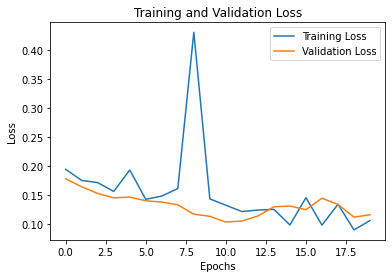

In [64]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### c-index

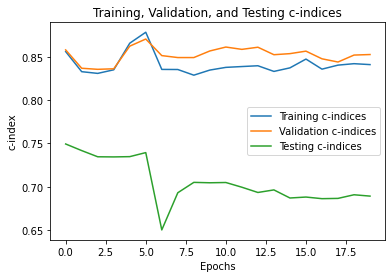

In [65]:
plt.plot(train_c_indices, label='Training c-indices')
plt.plot(val_c_indices, label='Validation c-indices')
plt.plot(test_c_indices, label='Testing c-indices')
#plt.plot(test_c_indices_trunc_10year, label='Testing c-indices (for truncation at 10 years)')
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('c-index')
plt.title('Training, Validation, and Testing c-indices')
plt.legend()
plt.show()

# Get the predicted hazard of DH dataset

##### Build prediction model

In [69]:
prediction_model = MultimodalPairwiseTrilinear(HiTIMED_encoder.to(device),
                                               DNAm_encoder.to(device),
                                               wsi_encoder.to(device),
                                               32,32,32,
                                               hidden_dim = 50).to(device).double()

##### Load trained model

In [64]:
best_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/Multimodal/model_saving/Pheno_Interaction/model_best.pth')
best_state_dict

OrderedDict([('HiTIMEDEncoder.input_layer.weight',
              tensor([[-0.1308,  0.0645, -0.0009,  ..., -0.0048, -0.1004, -0.0590],
                      [-0.0685,  0.0467, -0.0676,  ...,  0.1801,  0.0233, -0.0017],
                      [ 0.0065, -0.1329,  0.1967,  ...,  0.3356,  0.0911, -0.0187],
                      ...,
                      [-0.1026,  0.0764,  0.0295,  ..., -0.0297,  0.0640, -0.0605],
                      [-0.1162,  0.0783, -0.0867,  ..., -0.0596,  0.2322,  0.0220],
                      [-0.0858,  0.0363, -0.0085,  ...,  0.1014, -0.1380, -0.0527]],
                     device='cuda:0', dtype=torch.float64)),
             ('HiTIMEDEncoder.input_layer.bias',
              tensor([-1.1542e-01, -2.8186e-04, -5.1804e-02, -3.5750e-03, -1.2161e-01,
                      -3.0322e-02, -2.0715e-02, -1.6112e-02,  2.8139e-02, -7.8413e-02,
                      -1.1794e-01, -1.5811e-01, -1.4265e-01, -8.4523e-02, -3.3547e-02,
                      -1.1752e-01, -1.8095e-01

In [70]:
prediction_model.load_state_dict(best_state_dict)

<All keys matched successfully>

### Get hazards

In [71]:
hazards = []
prediction_model.eval()
prediction_model.train(False)
with torch.no_grad():
    for idx,data in enumerate(test_loader):
        
        HiTIMED_data = data[0].to(device)
        dnam_data = data[1].to(device)
        wsi_data = data[2]
        demog = data[3].to(device)
        
        
        censors = torch.Tensor(wsi_data.censor)
        times = wsi_data.duration
        edge_index = wsi_data.edge_index.to(device)
        batch = wsi_data.batch.to(device)
        wsi_data = wsi_data.x.double().to(device)
        
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(censors.isnan()): # pop up an error: 'list' object has no attribute 'isnan'
            censors = torch.nan_to_num(censors)
            
        hazard_pred = prediction_model(HiTIMED_data, dnam_data, wsi_data, edge_index, batch, demog)
        
        hazards_pred = hazard_pred.cpu().numpy()
        
        for i in hazards_pred:
            hazards.append(i.item())

### Merge to the original data frame

In [76]:
predicted_df = Data_DH_final[['FFPE.DNA.ID','Blood.Sample.ID','death_stat','death_censor_time','TenDead','TenYearSurv','RFS_stat','RFS_censor_time','TenRFS','TenYearRFS','Sex','Age']].copy()
predicted_hazards = hazards
predicted_df['predicted_hazard_WSI'] = predicted_hazards
predicted_df

,FFPE.DNA.ID,Blood.Sample.ID,death_stat,death_censor_time,TenDead,TenYearSurv,RFS_stat,RFS_censor_time,TenRFS,TenYearRFS,Sex,Age,predicted_hazard_WSI
0,BLD050,A00000FBK,1,3816.344970,0,3600.0,1,3816.344970,0,3600.000000,male,77,-0.107488
1,BLD043,A00000FC3,1,4869.979467,0,3600.0,1,4869.979467,0,3600.000000,female,77,-9.339047
2,BLD043,A00000FC3,1,4869.979467,0,3600.0,1,4869.979467,0,3600.000000,female,77,-9.322425
3,BLD061,A00000EH7,0,3780.000000,0,3600.0,0,3780.000000,0,3600.000000,female,76,-0.230495
4,BLD061,A00000EH7,0,3780.000000,0,3600.0,0,3780.000000,0,3600.000000,female,76,-0.234401
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,BLD048,BDB1P03023,1,3609.363450,0,3600.0,1,3609.363450,0,3600.000000,male,58,-3.063585
132,BLD075,BDB1P04022,0,4230.000000,0,3600.0,0,4230.000000,0,3600.000000,male,51,-8.735399
133,BLD024,BDB1P02094,0,4500.000000,0,3600.0,0,4500.000000,0,3600.000000,male,68,-0.456061
134,BLD094,BDB1P03058,0,4410.000000,0,3600.0,1,1999.232877,1,1999.232877,male,53,-6.837567


### Save

In [77]:
predicted_df.to_csv('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/Multimodal/predicted_hazards_Multimodal.csv')